In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from catboost import CatBoostRegressor
import datetime
from sklearn import preprocessing
from matplotlib import pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def predict_horizon(model, training_df, test_df, feature_list, num_predictions=8):
    start_period = 0
    end_period = num_predictions
    prediction_list = []
    
    # We generate an encoder for ns feature
    if 'Country' in feature_list:
        ns_encoder = preprocessing.LabelEncoder()
        training_df['Country'] =  ns_encoder.fit_transform(training_df['Country'])
    
    x_training_df = training_df[feature_list].copy()
    y_training_df = training_df['Cases'].copy().to_frame()
    model.fit(x_training_df, np.ravel(y_training_df))
    
    # Predicting on test set, while end period is not equal to end of length of test_df
    while end_period <= len(test_df):
        # Collect features from start to end (67 hours) and predict
        features_df = test_df[feature_list][start_period:end_period].copy()
        if 'Country' in feature_list:
            features_df['Country'] = ns_encoder.transform(features_df['Country'])
        true_df = test_df[['Cases']][start_period:end_period].copy()
        predictions = model.predict(features_df)
       
        # Add the predicted data
        predicted_df = pd.DataFrame(predictions, columns=['predicted'])
        predicted_df.index = true_df.index.copy()        
        prediction_list.extend(predictions)
        # Move to next period
        start_period += 1
        end_period += 1
    
    test_df = test_df.assign(Predicted=prediction_list)
    return test_df


In [4]:
def MAPE(df,true_column,pred_column):
    true_list = df[true_column].to_numpy()
    pred_list = df[pred_column].to_numpy()

    return np.mean(np.abs((true_list - pred_list) / true_list)) * 100

In [5]:
def true_predicted_fig(true_df, predicted_df, title_str):
    fig,ax = plt.subplots(figsize=[12,4])
    p_t_max = np.max(np.maximum(true_df[:8]['Cases'].values,predicted_df[:8]['Predicted'].values))
    p_t_min = np.min(np.minimum(true_df[:8]['Cases'].values,predicted_df[:8]['Predicted'].values))
    t1 = ax.plot(true_df.index[:8], true_df[:8]['Cases'], 'black')
    ax.set_ylabel('Cases')
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(title_str)
    p1 = ax.plot(predicted_df.index[:8], predicted_df[:8]['Predicted'], 'Red', linewidth=3)
    ax.legend((t1[0], p1[0]), ('True', 'Predicted'), loc=1, frameon=True)

In [6]:
def accumulated_dataframe_column(df_test,cluster_CB_df):
    test_start_value = df_test.loc[df_test.index == datetime.datetime(2020,9,9), 'cases_tot'].values[0]
    cluster_CB_df['Accumulated_Prediction']=0
    cluster_CB_df['Accumulated_Prediction'][0] = test_start_value + cluster_CB_df['Predicted'][0]
    for i in range(1,len(cluster_CB_df)):
        cluster_CB_df['Accumulated_Prediction'][i] = cluster_CB_df['Accumulated_Prediction'][i-1]+cluster_CB_df['Predicted'][i]
    return cluster_CB_df

In [7]:
df_z = pd.read_parquet('../../data/pre_processed/covid_cases_z_trans.parquet')

In [8]:
hac_z = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='single')
hac_z= hac_z.fit(df_z.T)

In [9]:
#The labels for the HAC-clustering 
labels_hac_z = hac_z.labels_
labels_hac_z

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
print("HAC:")
print("Countries in cluster 0:", np.count_nonzero(labels_hac_z == 0))
print("Countries in cluster 1:", np.count_nonzero(labels_hac_z == 1))
print("Countries in cluster 2:", np.count_nonzero(labels_hac_z == 2))
print("Countries in cluster 3:", np.count_nonzero(labels_hac_z == 3))

HAC:
Countries in cluster 0: 78
Countries in cluster 1: 1
Countries in cluster 2: 1
Countries in cluster 3: 1


In [11]:
#Make a new data frame for each cluster
df_hac_z_0 = df_z.T.loc[labels_hac_z == 0].transpose()
df_hac_z_1 = df_z.T.loc[labels_hac_z == 1].transpose()
df_hac_z_2 = df_z.T.loc[labels_hac_z == 2].transpose()
df_hac_z_3 = df_z.T.loc[labels_hac_z == 3].transpose()

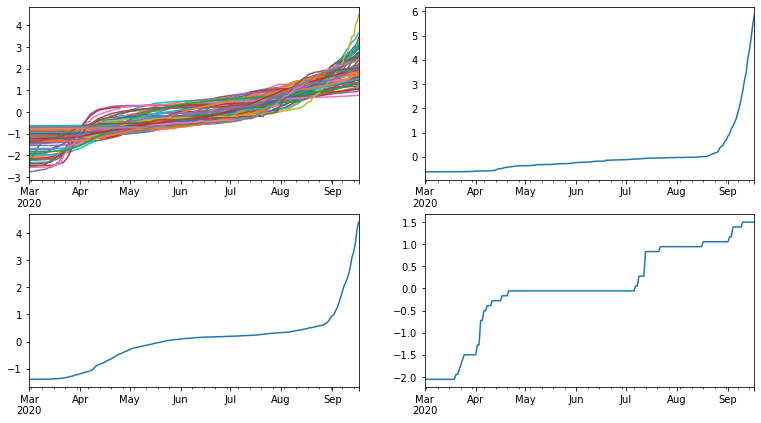

In [12]:
#Make a figure with the four clusters
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(13, 7)
df_hac_z_0.plot(legend='', ax=axes[0,0])
df_hac_z_1.plot(legend='', ax=axes[0,1])
df_hac_z_2.plot(legend='', ax=axes[1,0])
df_hac_z_3.plot(legend='', ax=axes[1,1])

## Selecting test countries

In [13]:
df_forecasting = pd.read_parquet('../../data/forecasting_format/dataframe_forecasting_with_features.parquet')

In [14]:
Algeria_df = df_forecasting [df_forecasting['Country'].isin(['Algeria'])]

In [15]:
test_1_df =  Algeria_df[(Algeria_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Algeria_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [16]:
Belgium_df = df_forecasting[df_forecasting['Country'].isin(['Belgium'])]

In [17]:
test_2_df =  Belgium_df[(Belgium_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Belgium_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [18]:
Bangladesh_df = df_forecasting[df_forecasting['Country'].isin(['Bangladesh'])]

In [19]:
test_3_df =  Bangladesh_df[(Bangladesh_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Bangladesh_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [20]:
Croatia_df = df_forecasting[df_forecasting['Country'].isin(['Croatia'])]

In [21]:
test_4_df =  Croatia_df[(Croatia_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Croatia_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [22]:
selected_clusters = []
test_countries_not_used = []

In [23]:
def forecasting(hac_countries_list,hac_df,country_df,test_df):
    hac_df = df_forecasting[df_forecasting['Country'].isin(hac_countries_list)]
    hac_training_df = hac_df[(hac_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (hac_df.index.date <= datetime.date(2020, 9, 9))].copy()
    feature_list = ['Country','Month','Day','prev_case']
    params= {'iterations': 5000, 'silent': True}
    model = CatBoostRegressor(**params)
    hac_CB_df = predict_horizon(model=model, training_df=hac_training_df.copy(), 
                                                             test_df=test_df.copy(),
                                                             feature_list=feature_list)
    hac_CB_df = accumulated_dataframe_column(country_df,hac_CB_df)
    return hac_CB_df

## Hierarchical, cluster with Algeria

Select correct cluster

In [24]:
if 'Algeria' in df_hac_z_0.columns and 'df_hac_z_0' not in selected_clusters:
    hac_1_df = df_hac_z_0.copy()
    selected_clusters.append('df_hac_z_0')
elif 'Algeria' in df_hac_z_1.columns and 'df_hac_z_1' not in selected_clusters:
    hac_1_df = df_hac_z_1.copy()
    selected_clusters.append('df_hac_z_1')
elif 'Algeria' in df_hac_z_2.columns and 'df_hac_z_2' not in selected_clusters:
    hac_1_df = df_hac_z_2.copy()
    selected_clusters.append('df_hac_z_2')
elif 'Algeria' in df_hac_z_3.columns and 'df_hac_z_3' not in selected_clusters:
    hac_1_df = df_hac_z_3.copy()
    selected_clusters.append('df_hac_z_3')
else:
    test_countries_not_used.append('Algeria')

In [25]:
print(selected_clusters)
print(test_countries_not_used)

['df_hac_z_0']
[]


In [26]:
if 'Algeria' not in test_countries_not_used:
    hac_1_countries_list = list(hac_1_df.columns)
    hac_1_CB_df = forecasting(hac_1_countries_list,hac_1_df,Algeria_df,test_1_df)

In [27]:
print(hac_1_countries_list)

['Algeria', 'Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belarus', 'Belgium', 'Bolivia', 'Bulgaria', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Czech Republic', 'Denmark', 'Dominican Republic', 'El Salvador', 'Estonia', 'Ethiopia', 'Finland', 'Ghana', 'Greece', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Japan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Malawi', 'Malaysia', 'Malta', 'Mexico', 'Morocco', 'Mozambique', 'Nepal', 'New Zealand', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Romania', 'Russia', 'Rwanda', 'Saudi Arabia', 'Senegal', 'Serbia', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Sri Lanka', 'Sweden', 'Switzerland', 'Thailand', 'Togo', 'Tunisia', 'Turkey', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay', 'Vietnam', 'Zambia', 'Zimbabwe']


In [28]:
print(len(hac_1_countries_list))

78


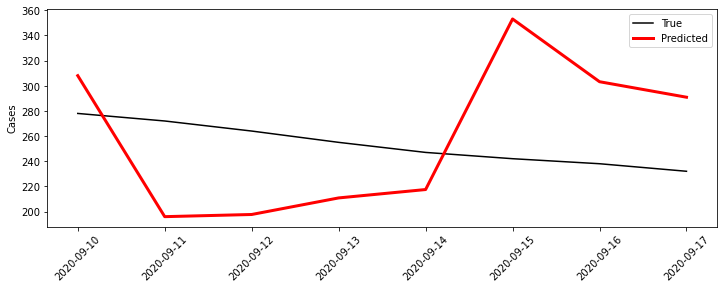

In [29]:
title_str =''
true_predicted_fig(test_1_df,hac_1_CB_df,title_str)

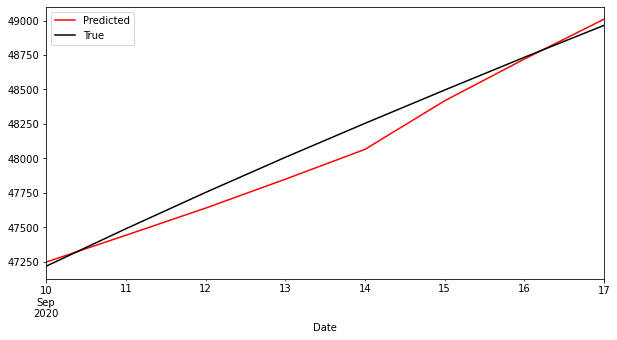

In [30]:
hac_1_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

MAPE k_means 1:

In [31]:
round(MAPE(hac_1_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.1754

## Hierarcical cluster with Belgium

Select correct cluster

In [36]:
if 'Belgium' in df_hac_z_0.columns and 'df_hac_z_0' not in selected_clusters:
    hac_2_df = df_hac_z_0.copy()
    selected_clusters.append('df_hac_z_0')
elif 'Belgium' in df_hac_z_1.columns and 'df_hac_z_1' not in selected_clusters:
    hac_2_df = df_hac_z_1.copy()
    selected_clusters.append('df_hac_z_1')
elif 'Belgium' in df_hac_z_2.columns and 'df_hac_z_2' not in selected_clusters:
    hac_2_df = df_hac_z_2.copy()
    selected_clusters.append('df_hac_z_2')
elif 'Belgium' in df_hac_z_3.columns and 'df_hac_z_3' not in selected_clusters:
    hac_2_df = df_hac_z_3.copy()
    selected_clusters.append('df_hac_z_3')
else:
    test_countries_not_used.append('Belgium')

In [33]:
print(selected_clusters)
print(test_countries_not_used)

['df_hac_z_0']
['Belgium']


In [34]:
if 'Belgium' not in test_countries_not_used:
    hac_2_countries_list = list(hac_2_df.columns)
    hac_2_CB_df = forecasting(hac_2_countries_list,hac_2_df,Belgium_df,test_2_df)

In [35]:
print(hac_2_countries_list)

NameError: name 'hac_2_countries_list' is not defined

In [ ]:
print(len(hac_2_countries_list))

In [ ]:
title_str =''
true_predicted_fig(test_2_df,hac_2_CB_df,title_str)

In [ ]:
hac_2_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

MAPE hac 2:

In [ ]:
round(MAPE(hac_2_CB_df,'cases_tot','Accumulated_Prediction'),4)

## HAC, cluster with Bangladesh

Select correct cluster

In [37]:
if 'Bangladesh' in df_hac_z_0.columns and 'df_hac_z_0' not in selected_clusters:
    hac_3_df = df_hac_z_0.copy()
    selected_clusters.append('df_hac_z_0')
elif 'Bangladesh' in df_hac_z_1.columns and 'df_hac_z_1' not in selected_clusters:
    hac_3_df = df_hac_z_1.copy()
    selected_clusters.append('df_hac_z_1')
elif 'Bangladesh' in df_hac_z_2.columns and 'df_hac_z_2' not in selected_clusters:
    hac_3_df = df_hac_z_2.copy()
    selected_clusters.append('df_hac_z_2')
elif 'Bangladesh' in df_hac_z_3.columns and 'df_hac_z_3' not in selected_clusters:
    hac_3_df = df_hac_z_3.copy()
    selected_clusters.append('df_hac_z_3')
else:
    test_countries_not_used.append('Bangladesh')

In [38]:
df_hac_z_3.columns

Index(['Fiji'], dtype='object')

In [39]:
print(selected_clusters)
print(test_countries_not_used)

['df_hac_z_0']
['Belgium', 'Belgium', 'Bangladesh']


In [40]:
if 'Bangladesh' not in test_countries_not_used:
    hac_3_countries_list = list(hac_3_df.columns)
    hac_3_CB_df = forecasting(hac_3_countries_list,hac_3_df,Bangladesh_df,test_3_df)

In [41]:
print(hac_3_countries_list)

NameError: name 'hac_3_countries_list' is not defined

In [ ]:
print(len(hac_3_countries_list))

In [ ]:
title_str =''
true_predicted_fig(test_3_df,hac_3_CB_df,title_str)

In [ ]:
hac_3_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

MAPE hac 3:

In [ ]:
round(MAPE(hac_3_CB_df,'cases_tot','Accumulated_Prediction'),4)

## HAC, cluster with Croatia

Select correct cluster

In [42]:
if 'Croatia' in df_hac_z_0.columns and 'df_hac_z_0' not in selected_clusters:
    hac_4_df = df_hac_z_0.copy()
    selected_clusters.append('df_hac_z_0')
elif 'Croatia' in df_hac_z_1.columns and 'df_hac_z_1' not in selected_clusters:
    hac_4_df = df_hac_z_1.copy()
    selected_clusters.append('df_hac_z_1')
elif 'Croatia' in df_hac_z_2.columns and 'df_hac_z_2' not in selected_clusters:
    hac_4_df = df_hac_z_2.copy()
    selected_clusters.append('df_hac_z_2')
elif 'Croatia' in df_hac_z_3.columns and 'df_hac_z_3' not in selected_clusters:
    hac_4_df = df_hac_z_3.copy()
    selected_clusters.append('df_hac_z_3')
else:
    test_countries_not_used.append('Croatia')

In [43]:
print(selected_clusters)
print(test_countries_not_used)

['df_hac_z_0']
['Belgium', 'Belgium', 'Bangladesh', 'Croatia']


In [44]:
if 'Croatia' not in test_countries_not_used:
    hac_4_countries_list = list(hac_4_df.columns)
    hac_4_CB_df = forecasting(hac_4_countries_list,hac_4_df,Croatia_df,test_4_df)

In [45]:
print(hac_4_countries_list)

NameError: name 'hac_4_countries_list' is not defined

In [ ]:
print(len(hac_4_countries_list))

In [ ]:
title_str =''
true_predicted_fig(test_4_df,hac_4_CB_df,title_str)

In [ ]:
hac_4_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

MAPE hac 4:

In [ ]:
round(MAPE(hac_4_CB_df,'cases_tot','Accumulated_Prediction'),4)

Total MAPE

In [ ]:
round(MAPE(hac_1_CB_df,'cases_tot','Accumulated_Prediction')+MAPE(hac_2_CB_df,'cases_tot','Accumulated_Prediction')+MAPE(hac_3_CB_df,'cases_tot','Accumulated_Prediction')+MAPE(hac_4_CB_df,'cases_tot','Accumulated_Prediction'),4)